In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report

from xgboost import XGBClassifier

In [2]:
def plot_confusion_matrix(y_test, y_pred):
    conf = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf, annot=True, fmt='d', cmap='Blues', xticklabels=['No','Yes'], yticklabels=['No','Yes'])
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.title('Confusion Matrix')
    plt.show()

In [3]:
def plot_roc_curve(y_test, y_pred):
    fpr, tpr, threshold = roc_curve(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr)
    plt.plot([0,1], [0,1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Postive Rate')
    plt.ylabel('True Postive Rate')
    plt.show()

### Loading the csv file

In [4]:
df = pd.read_csv('emp_attrition.csv')
df.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,EducationField,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,YearsAtCompany
0,33,Yes,Travel_Frequently,Research & Development,3,Life Sciences,1,Male,3,1,Research Scientist,1,3348,1,Yes,11,3,10
1,32,Yes,Travel_Rarely,Sales,4,Medical,4,Male,1,3,Sales Executive,4,10400,1,No,11,3,14
2,40,Yes,Travel_Rarely,Research & Development,9,Life Sciences,4,Male,3,1,Laboratory Technician,1,2018,3,No,14,3,5
3,42,No,Travel_Rarely,Research & Development,7,Medical,2,Female,4,2,Research Scientist,2,2372,6,Yes,16,3,1
4,43,No,Travel_Frequently,Research & Development,27,Life Sciences,3,Female,3,3,Manufacturing Director,1,10820,8,No,11,3,8


**Data Preparation**

**Encode the categorical variables.**

In [5]:
for i in df.columns:
    if df[i].dtype == 'object':
        df[i] = pd.Categorical(df[i]).codes

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1580 entries, 0 to 1579
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Age                      1580 non-null   int64
 1   Attrition                1580 non-null   int8 
 2   BusinessTravel           1580 non-null   int8 
 3   Department               1580 non-null   int8 
 4   DistanceFromHome         1580 non-null   int64
 5   EducationField           1580 non-null   int8 
 6   EnvironmentSatisfaction  1580 non-null   int64
 7   Gender                   1580 non-null   int8 
 8   JobInvolvement           1580 non-null   int64
 9   JobLevel                 1580 non-null   int64
 10  JobRole                  1580 non-null   int8 
 11  JobSatisfaction          1580 non-null   int64
 12  MonthlyIncome            1580 non-null   int64
 13  NumCompaniesWorked       1580 non-null   int64
 14  OverTime                 1580 non-null   int8 
 15  Perc

**Remove the outlier using IQR method, if present.**

In [7]:
def detect_outlier(col):
    Q1, Q3 = np.percentile(col, [25, 75])
    IQR = Q3 - Q1
    lr, ur = Q1 - 1.5*(IQR), Q3 + 1.5*(IQR)
    return lr, ur

In [8]:
detect_outlier(df['Age'])

(11.5, 55.5)

In [9]:
for i in df.columns:
    for j in range(len(df)):
        if (df[i].loc[j] < detect_outlier(df[i])[0]) or (df[i].loc[j] > detect_outlier(df[i])[1]):
            df.drop(j, axis=0, inplace=True)
    df.reset_index(drop=True, inplace=True)

In [10]:
df.shape

(1437, 18)

### Let's begin with some hands-on practice exercises

### 1. Convert the Age variable into categorical by dividing it in the ranges; 18-30, 31-40, 41-50, 51-60.

In [11]:
df['Age_Cat'] = ''

condlist = [
    (df['Age'] > 18) & (df['Age'] <= 30),
    (df['Age'] > 30) & (df['Age'] <= 40),
    (df['Age'] > 40) & (df['Age'] <= 50),
    (df['Age'] > 50) & (df['Age'] <= 60)
]
choicelist = ['18-30', '31-40', '41-50', '51-60']

df['Age_Cat'] = np.select(condlist, choicelist)

### 2. Employee from which age category has the highest salary?.

In [12]:
df[df['MonthlyIncome'] == df['MonthlyIncome'].max()]['Age_Cat'].values[0]

'18-30'

### 3. Dummy encode the categorical variable "Age".

In [13]:
df['Age_Cat'] = pd.Categorical(df['Age_Cat']).codes
df.drop('Age', axis=1, inplace=True)

In [14]:
df.head()

,Attrition,BusinessTravel,Department,DistanceFromHome,EducationField,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,YearsAtCompany,Age_Cat
0,1,1,1,3,1,1,1,3,1,6,1,3348,1,1,11,3,10,2
1,1,2,2,4,3,4,1,1,3,7,4,10400,1,0,11,3,14,2
2,1,2,1,9,1,4,1,3,1,2,1,2018,3,0,14,3,5,2
3,0,2,1,7,3,2,0,4,2,6,2,2372,6,1,16,3,1,3
4,0,1,1,27,1,3,0,3,3,4,1,10820,8,0,11,3,8,3


## 1. ADABoost

### 4. Build a adaboost model with 40 number of estimators to predict whether or not an employee will leave the company based on all the dummy encoded categorical features only. Calculate the accuracy for the model.

In [15]:
AdaBoostClassifier().get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': 'deprecated',
 'estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': None}

In [16]:
X = df.drop('Attrition', axis=1)
y = df[['Attrition']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

dummy_encoded_col = []
for i in X.columns:
    if df[i].dtype == 'int8':
        dummy_encoded_col.append(i)

In [17]:
model4 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5), n_estimators=40)
model4.fit(X_train[dummy_encoded_col], y_train)

model4.score(X_test[dummy_encoded_col], y_test)

0.8148148148148148

### 5. Build a adaboost full model with 40 number of estimators to predict if an employee will leave the company. Generate a classification report.

In [18]:
X = df.drop('Attrition', axis=1)
y = df[['Attrition']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model5 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5), n_estimators=40)
model5.fit(X_train, y_train)

print('Accuracy =',model5.score(X_test, y_test))

y_pred5 = pd.DataFrame(model5.predict(X_test), index=y_test.index, columns=['Attrition'])
print(classification_report(y_test, y_pred5))

Accuracy = 0.9675925925925926
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       239
           1       0.96      0.97      0.96       193

    accuracy                           0.97       432
   macro avg       0.97      0.97      0.97       432
weighted avg       0.97      0.97      0.97       432



### 6. Find the area under the receiver operating characteristic curve for full model built in question 5.

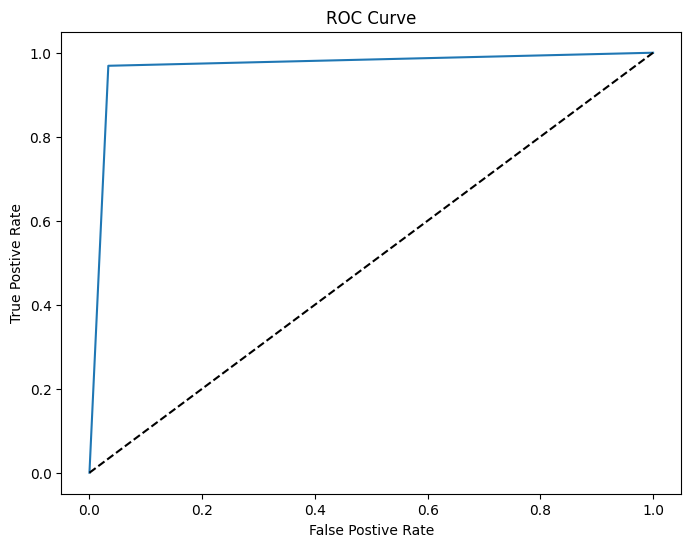

AUC = 0.9677195568755826


In [19]:
plot_roc_curve(y_test, y_pred5)
print('AUC =',roc_auc_score(y_test, y_pred5))

### 7. Plot a confusion matrix for the full model built above.

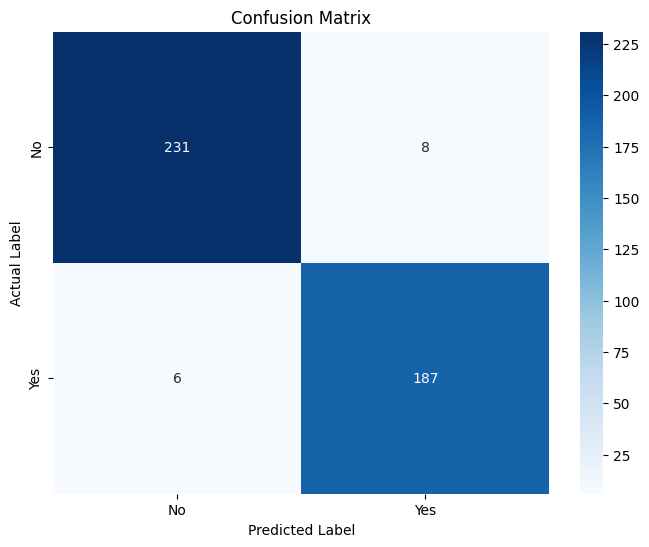

In [20]:
plot_confusion_matrix(y_test, y_pred5)

### 8. Calculate the specificity, sensitivity, % of misclassified and correctly classified observations. What can you say about the model by looking at the sensitivity and specificity values? Is this a good model?

### 9. Find the best value of hyperparameters "n_estimators" and "learning_rate" for the adaboost full model.

Given list of values:

       n_estimators = [100, 120, 150, 200, 250, 300, 350],
       learning_rate = [0.1, 0.01, 0.001, 0.15, 0.015]  

In [21]:
X = df.drop('Attrition', axis=1)
y = df[['Attrition']]

param_grid = {'n_estimators': [100, 120, 150, 200, 250, 300, 350], 'learning_rate': [0.1, 0.01, 0.001, 0.15, 0.015]}

grid_search1 = GridSearchCV(AdaBoostClassifier(), param_grid, cv=10, scoring='accuracy')
grid_search1.fit(X, y)

GridSearchCV(cv=10, estimator=AdaBoostClassifier(),
             param_grid={'learning_rate': [0.1, 0.01, 0.001, 0.15, 0.015],
                         'n_estimators': [100, 120, 150, 200, 250, 300, 350]},
             scoring='accuracy')

### 10. Build a adaboost model using the tuned hyperparameters, perform 10 fold cross validation and get the average ROC-AUC score.

In [22]:
auc = []
kf = KFold(10)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

    model10 = grid_search1.best_estimator_
    model10.fit(X_train, y_train)

    y_pred10 = pd.DataFrame(model10.predict(X_test), index=y_test.index, columns=['Attrition'])
    auc.append(roc_auc_score(y_test, y_pred10))

print(auc)
print('Average ROC-AUC Score =',np.mean(auc))

[0.8140143438650901, 0.791958041958042, 0.8190237314296739, 0.7152777777777777, 0.7843749999999999, 0.7843629343629344, 0.7462962962962963, 0.770392156862745, 0.7833333333333333, 0.7529988004798082]
Average ROC-AUC Score = 0.7762032416365701


## 2. Gradient Boosting

### 11. Build the gradient boosting model 100 estimators and maximum depth 3. Also, find the accuracy score.

In [23]:
GradientBoostingClassifier().get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [24]:
X = df.drop('Attrition', axis=1)
y = df[['Attrition']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model11 = GradientBoostingClassifier()
model11.fit(X_train, y_train)

model11.score(X_test, y_test)

0.9050925925925926

### 12. Find the best value of hyperparameters "n_estimators", "learning_rate" and "max_depth" for the gradient boosting full model.

Given list of values:

        n_estimators = [100, 120, 150, 200, 250, 300, 350],
        learning_rate = [0.1, 0.01, 0.001, 0.15, 0.015], 
        max_depth = [2, 3, 4, 5, 6]

In [25]:
X = df.drop('Attrition', axis=1)
y = df[['Attrition']]

param_grid = {'n_estimators': [100, 120, 150, 200, 250, 300, 350], 'learning_rate': [0.1, 0.01, 0.001, 0.15, 0.015], 'max_depth': [2,3,4,5,6]}

grid_search2 = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=3, scoring='accuracy')
grid_search2.fit(X, y)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.1, 0.01, 0.001, 0.15, 0.015],
                         'max_depth': [2, 3, 4, 5, 6],
                         'n_estimators': [100, 120, 150, 200, 250, 300, 350]},
             scoring='accuracy')

In [26]:
grid_search2.best_params_

{'learning_rate': 0.15, 'max_depth': 6, 'n_estimators': 250}

### 13. Build the gradient boosting model and an adaboost model with their best parameters and generate a classification report for both of them. Which model is the best and why?

In [27]:
X = df.drop('Attrition', axis=1)
y = df[['Attrition']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model_ada = grid_search1.best_estimator_
model_ada.fit(X_train, y_train)

y_pred_ada = pd.DataFrame(model_ada.predict(X_test), index=y_test.index, columns=['Attrition'])
print('classification report for adaboost')
print(classification_report(y_test, y_pred_ada))

print()

model_gd = grid_search2.best_estimator_
model_gd.fit(X_train, y_train)

y_pred_gd = pd.DataFrame(model_gd.predict(X_test), index=y_test.index, columns=['Attrition'])
print('classification report for gradient descent boosting')
print(classification_report(y_test, y_pred_gd))

classification report for adaboost
              precision    recall  f1-score   support

           0       0.82      0.79      0.81       239
           1       0.75      0.78      0.77       193

    accuracy                           0.79       432
   macro avg       0.78      0.79      0.79       432
weighted avg       0.79      0.79      0.79       432


classification report for gradient descent boosting
              precision    recall  f1-score   support

           0       0.98      0.95      0.97       239
           1       0.94      0.98      0.96       193

    accuracy                           0.97       432
   macro avg       0.96      0.97      0.96       432
weighted avg       0.97      0.97      0.97       432



### 14. Plot the area under the receiver operating characteristic curve for tuned gradient boosting model built in question 13. Also plot a confusion matrix.

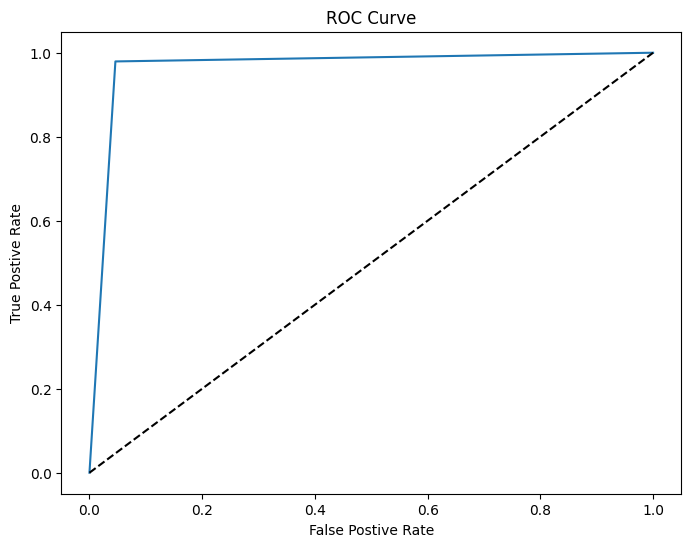

In [28]:
plot_roc_curve(y_test, y_pred_gd)

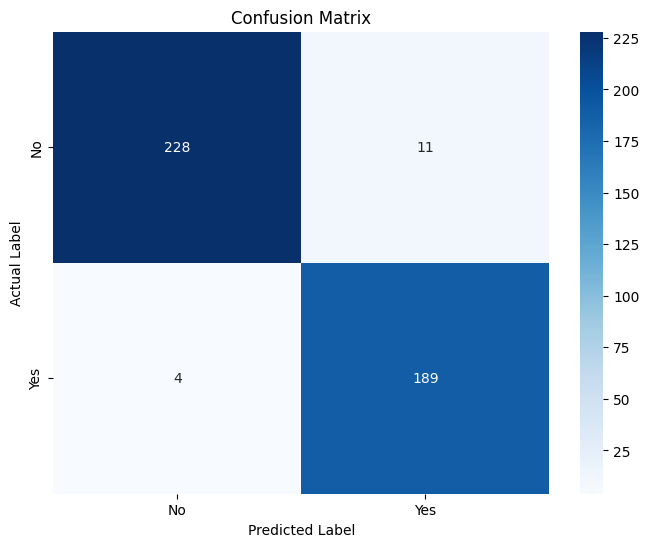

In [29]:
plot_confusion_matrix(y_test, y_pred_gd)

## 3. Extreme Gradient Boosting (XGBoost)

### 15. Build the XGBoost model with a learning rate of 0.01 and gamma equal to 2. Calculate the roc_auc score and generate a classification rerport.

In [30]:
#XGBClassifier().get_params()

In [31]:
X = df.drop('Attrition', axis=1)
y = df[['Attrition']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model15 = XGBClassifier(learning_rate=0.01, gamma=2)
model15.fit(X_train, y_train)

y_pred15 = pd.DataFrame(model15.predict(X_test), index=y_test.index, columns=['Attrition'])
print('AUC =',roc_auc_score(y_test, y_pred15))
print('Classification Report:')
print(classification_report(y_test, y_pred15))

AUC = 0.874661261300323
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       239
           1       0.87      0.85      0.86       193

    accuracy                           0.88       432
   macro avg       0.88      0.87      0.88       432
weighted avg       0.88      0.88      0.88       432



### 16. Find the best value of hyperparameters "n_estimators", "learning_rate" and "max_depth" for the extreme gradient boosting full model.

Given list of values:

        n_estimators = [100, 120, 150],
        learning_rate = [0.1, 0.01, 0.001, 0.15, 0.015], 
        gamma = [2, 3, 4, 5, 6],
        max_depth = [2, 3, 4, 5, 6]

In [32]:
X = df.drop('Attrition', axis=1)
y = df[['Attrition']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

param_grid = {'n_estimators': [100, 120, 150], 'learning_rate': [0.1, 0.01, 0.001, 0.15, 0.015], 'max_depth': [2,3,4,5,6], 'gamma': [2,3,4,5,6]}

grid_search3 = GridSearchCV(XGBClassifier(), param_grid, cv=3, scoring='roc_auc')
grid_search3.fit(X, y)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'gamma': [2, 3, 4, 5, 6],
                         'learning_rate': [0.1, 0.01, 0.001, 0.15, 0.015],
                         'max_depth': [2, 3, 4, 5, 6],
                         'n_estimators': [100, 120, 150]},
             scoring='roc_auc')

### 17. Plot the connfusion matrix for tuned extreme gradient boosting model built in question 16.

In [33]:
model16 = grid_search3.best_estimator_
model16.fit(X_train, y_train)

y_pred16 = pd.DataFrame(model16.predict(X_test), index=y_test.index, columns=['Attrition'])

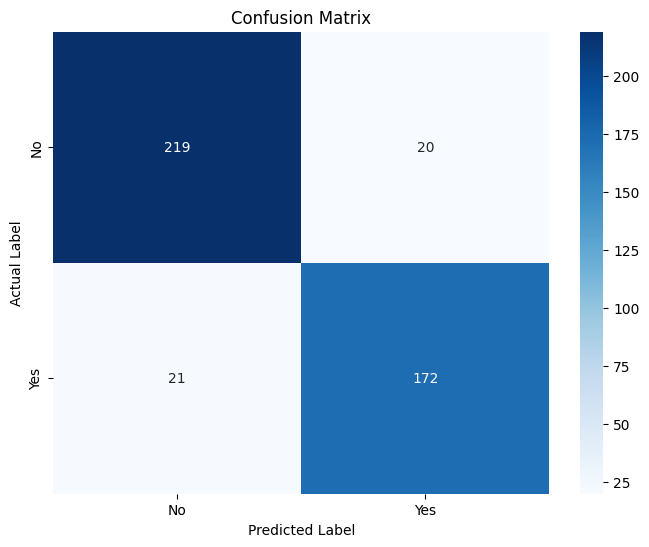

In [34]:
plot_confusion_matrix(y_test, y_pred16)

### 18. Plot the area under the receiver operating characteristic curve for tuned extreme gradient boosting model built in question 16.

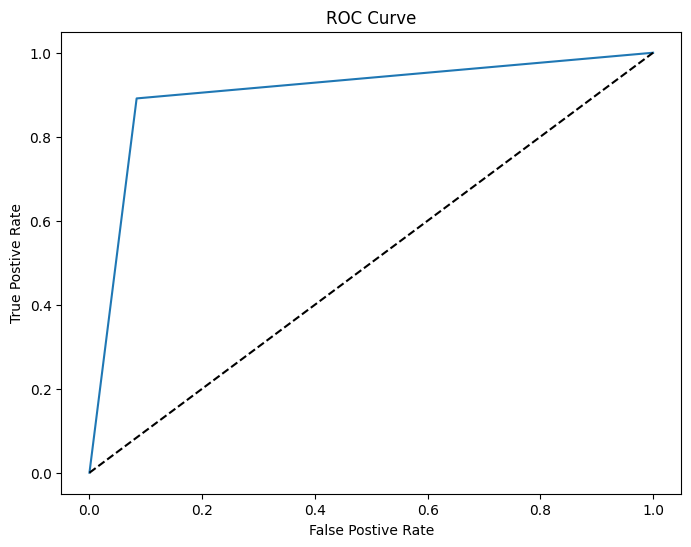

In [35]:
plot_roc_curve(y_test, y_pred16)

### 19. Use the stacking technique with the decision tree and Random Forest model as base learners. Consider the Adaboost model as a final estimator. Also, compute the ROC-AUC score of the model.

In [64]:
X = df.drop('Attrition', axis=1)
y = df[['Attrition']]

estimators = [DecisionTreeClassifier(), RandomForestClassifier()]

all_predictions = pd.DataFrame()
kf = KFold(10, shuffle=True)

for i in range(len(estimators)):
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]

        model = estimators[i]
        model.fit(X_train, y_train)

        model_pred_train = pd.DataFrame(model.predict(X_train), index=train_index)
        model_pred_test = pd.DataFrame(model.predict(X_test), index=test_index)

        a = pd.concat([model_pred_train, model_pred_test], axis=0)
        all_predictions = pd.concat([all_predictions, a.sort_index()], axis=1)

all_predictions.columns = list(range(20))

In [65]:
all_predictions.head(20)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [66]:
X_train, X_test, y_train, y_test = train_test_split(all_predictions, y, test_size=0.3, random_state=42)

model19 = AdaBoostClassifier()
model19.fit(X_train, y_train)

y_pred19 = pd.DataFrame(model19.predict(X_test), index=y_test.index, columns=['Attrition'])
print('AUC =',roc_auc_score(y_test, y_pred19))

AUC = 1.0


### 20. Use the stacking technique with the decision tree and Random Forest model as base learners. Consider the Gradient Boosting model as a final estimator. Also, compute the ROC-AUC score of the model.

In [67]:
X = df.drop('Attrition', axis=1)
y = df[['Attrition']]

estimators = [DecisionTreeClassifier(), RandomForestClassifier()]

all_predictions = pd.DataFrame()
kf = KFold(10, shuffle=True)

for i in range(len(estimators)):
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]

        model = estimators[i]
        model.fit(X_train, y_train)

        model_pred_train = pd.DataFrame(model.predict(X_train), index=train_index)
        model_pred_test = pd.DataFrame(model.predict(X_test), index=test_index)

        a = pd.concat([model_pred_train, model_pred_test], axis=0)
        all_predictions = pd.concat([all_predictions, a.sort_index()], axis=1)

all_predictions.columns = list(range(20))

X_train, X_test, y_train, y_test = train_test_split(all_predictions, y, test_size=0.3, random_state=42)

model20 = GradientBoostingClassifier()
model20.fit(X_train, y_train)

y_pred20 = pd.DataFrame(model20.predict(X_test), index=y_test.index, columns=['Attrition'])
print('AUC =',roc_auc_score(y_test, y_pred20))

AUC = 0.9974093264248705


In [68]:
model20.score(X_test, y_test)

0.9976851851851852